# 不動産価格予測モデル検討レポート

## 1. はじめに

本レポートでは、米国の特定地域の不動産売買データを用いて、不動産価格予測モデルを構築・評価する。  
本分析は、将来の同様データに対する価格予測サービスの有用性を評価し、事業化の可否や改善策を検討するための基礎資料となる。  

## 2. データ概要

対象データには以下の変数が含まれる。

- **date**: 売買成立日
- **price**: 売買価格(予測対象)
- **sqft_lot**: 敷地面積
- **sqft_living**: 居住スペース面積
- **grade**: 建築・デザイン品質評価(1～13)
- **lat**: 緯度
- **long**: 経度
- **yr_built**: 建築年
- **yr_renovated**: 最終リノベーション年(0は未リノベーション)

本分析では、`date` と `yr_renovated` をモデル利用可能な特徴量へ変換する。

## 3. 分析環境とパッケージ


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%matplotlib inline
sns.set_style("whitegrid")
pd.options.display.float_format = '{:,.2f}'.format


## 4. データ読み込みと基本確認

`data.csv` を読み込み、`date` を日付型へ変換する。


In [2]:
# データ読み込み
data = pd.read_csv("data.csv", dtype={'date': str})
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d')

# 初期データ確認
display(data.head())
display(data.info())


,date,price,sqft_lot,sqft_living,grade,lat,long,yr_built,yr_renovated
0,2014-10-13,221900,5650,1180,7,47.51,-122.26,1955,0
1,2014-12-09,538000,7242,2570,7,47.72,-122.32,1951,1991
2,2015-02-25,180000,10000,770,6,47.74,-122.23,1933,0
3,2014-12-09,604000,5000,1960,7,47.52,-122.39,1965,0
4,2015-02-18,510000,8080,1680,8,47.62,-122.05,1987,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          21613 non-null  datetime64[ns]
 1   price         21613 non-null  int64         
 2   sqft_lot      21613 non-null  int64         
 3   sqft_living   21613 non-null  int64         
 4   grade         21613 non-null  int64         
 5   lat           21613 non-null  float64       
 6   long          21613 non-null  float64       
 7   yr_built      21613 non-null  int64         
 8   yr_renovated  21613 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6)
memory usage: 1.5 MB


None

## 5. 特徴量エンジニアリング

ここで、`date` からの特徴量抽出と `yr_renovated` からの特徴量変換を行う。

- `date` を用いて `year_sold`, `month_sold`, `days_since_2014_01_01` を作成する
- `yr_renovated` を用いて、リノベーション有無フラグ(`renovated_flag`)およびリノベから売却までの経過年数(`years_since_renovation`)を作成する。

その後、統計量を再確認する。

In [3]:
base_date = pd.Timestamp("2014-01-01")
data['year_sold'] = data['date'].dt.year
data['month_sold'] = data['date'].dt.month
data['days_since_2014_01_01'] = (data['date'] - base_date).dt.days + 1

data['renovated_flag'] = (data['yr_renovated'] > 0).astype(int)
data['years_since_renovation'] = np.where(
    data['yr_renovated'] > 0,
    data['year_sold'] - data['yr_renovated'],
    0
)

# モデル用数値カラム
numeric_cols = [
    'price','sqft_lot','sqft_living','grade','lat','long','yr_built',
    'year_sold','month_sold','days_since_2014_01_01','renovated_flag','years_since_renovation'
]

describe_df = data[numeric_cols].describe()

# 表の表記を日本語に変更
describe_df = describe_df.rename(index={
    'count': '件数',
    'mean': '平均',
    'std': '標準偏差',
    'min': '最小',
    '25%': '25%',
    '50%': '中央値',
    '75%': '75%',
    'max': '最大'
})

# カラム名を日本語に変更
describe_df = describe_df.rename(columns={
    'price': '価格',
    'sqft_lot': '敷地面積',
    'sqft_living': '居住スペース面積',
    'grade': '建築・デザイン品質評価',
    'lat': '緯度',
    'long': '経度',
    'yr_built': '建築年',
    'year_sold': '売却年',
    'month_sold': '売却月',
    'days_since_2014_01_01': '2014年1月1日からの日数',
    'renovated_flag': 'リノベーションフラグ',
    'years_since_renovation': 'リノベーションからの経過年数'
})

describe_df = describe_df.applymap(lambda x: f"{x:,.2f}")
display(describe_df)


C:\Users\rainb\AppData\Local\Temp\ipykernel_12208\1450717754.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  describe_df = describe_df.applymap(lambda x: f"{x:,.2f}")


,価格,敷地面積,居住スペース面積,建築・デザイン品質評価,緯度,経度,建築年,売却年,売却月,2014年1月1日からの日数,リノベーションフラグ,リノベーションからの経過年数
件数,"21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00","21,613.00"
平均,"540,088.14","15,106.97","2,079.90",7.66,47.56,-122.21,"1,971.01","2,014.32",6.57,302.19,0.04,0.78
標準偏差,"367,127.20","41,420.51",918.44,1.18,0.14,0.14,29.37,0.47,3.12,113.05,0.20,4.90
最小,"75,000.00",520.00,290.00,1.00,47.16,-122.52,"1,900.00","2,014.00",1.00,122.00,0.00,-1.00
25%,"321,950.00","5,040.00","1,427.00",7.00,47.47,-122.33,"1,951.00","2,014.00",4.00,203.00,0.00,0.00
中央値,"450,000.00","7,618.00","1,910.00",7.00,47.57,-122.23,"1,975.00","2,014.00",6.00,289.00,0.00,0.00
75%,"645,000.00","10,688.00","2,550.00",8.00,47.68,-122.12,"1,997.00","2,015.00",9.00,413.00,0.00,0.00
最大,"7,700,000.00","1,651,359.00","13,540.00",13.00,47.78,-121.31,"2,015.00","2,015.00",12.00,512.00,1.00,80.00


## 5.2 エラーデータの除外とデータ再確認

リノベーションからの経過年数(`years_since_renovation`)が負の値となっているデータは、`yr_renovated` が `year_sold` より後になっているためエラーデータと判断し、除外します。エラーデータを除外した後、再度統計量を表で確認します。


In [4]:
# エラーデータの除外
initial_count = data.shape[0]
data = data[data['years_since_renovation'] >= 0]
filtered_count = data.shape[0]
removed_count = initial_count - filtered_count

print(f"除外前のデータ件数: {initial_count}")
print(f"除外後のデータ件数: {filtered_count}")
print(f"除外したエラーデータの件数: {removed_count}")

# 再度統計量を確認
describe_df = data[numeric_cols].describe()

# 表の表記を日本語に変更
describe_df = describe_df.rename(index={
    'count': '件数',
    'mean': '平均',
    'std': '標準偏差',
    'min': '最小',
    '25%': '25%',
    '50%': '中央値',
    '75%': '75%',
    'max': '最大'
})

# カラム名を日本語に変更
describe_df = describe_df.rename(columns={
    'price': '価格',
    'sqft_lot': '敷地面積',
    'sqft_living': '居住スペース面積',
    'grade': '建築・デザイン品質評価',
    'lat': '緯度',
    'long': '経度',
    'yr_built': '建築年',
    'year_sold': '売却年',
    'month_sold': '売却月',
    'days_since_2014_01_01': '2014年1月1日からの日数',
    'renovated_flag': 'リノベーションフラグ',
    'years_since_renovation': 'リノベーションからの経過年数'
})

describe_df = describe_df.applymap(lambda x: f"{x:,.2f}")
display(describe_df)


除外前のデータ件数: 21613
除外後のデータ件数: 21607
除外したエラーデータの件数: 6


C:\Users\rainb\AppData\Local\Temp\ipykernel_12208\847938704.py:42: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  describe_df = describe_df.applymap(lambda x: f"{x:,.2f}")


,価格,敷地面積,居住スペース面積,建築・デザイン品質評価,緯度,経度,建築年,売却年,売却月,2014年1月1日からの日数,リノベーションフラグ,リノベーションからの経過年数
件数,"21,607.00","21,607.00","21,607.00","21,607.00","21,607.00","21,607.00","21,607.00","21,607.00","21,607.00","21,607.00","21,607.00","21,607.00"
平均,"540,061.05","15,107.16","2,079.59",7.66,47.56,-122.21,"1,971.01","2,014.32",6.57,302.22,0.04,0.78
標準偏差,"367,158.09","41,425.79",918.31,1.18,0.14,0.14,29.37,0.47,3.12,113.05,0.20,4.90
最小,"75,000.00",520.00,290.00,1.00,47.16,-122.52,"1,900.00","2,014.00",1.00,122.00,0.00,0.00
25%,"321,725.00","5,040.00","1,423.50",7.00,47.47,-122.33,"1,951.00","2,014.00",4.00,203.00,0.00,0.00
中央値,"450,000.00","7,618.00","1,910.00",7.00,47.57,-122.23,"1,975.00","2,014.00",6.00,289.00,0.00,0.00
75%,"645,000.00","10,687.50","2,550.00",8.00,47.68,-122.12,"1,997.00","2,015.00",9.00,413.00,0.00,0.00
最大,"7,700,000.00","1,651,359.00","13,540.00",13.00,47.78,-121.31,"2,015.00","2,015.00",12.00,512.00,1.00,80.00


## 5.3 追加のデータクリーニングと異常値の処理

前回のデータ再確認において、`years_since_renovation` や `sqft_lot` に異常値や極端な値が存在することが判明しました。これらの異常値はモデルの性能に悪影響を及ぼす可能性があるため、次のステップとしてさらなるデータクリーニングを実施します。

### 1. 敷地面積 (`sqft_lot`) の異常値の検出と処理

**問題点**:
- 最大値が **1,651,359.00** 平方フィートとなっており、現実的な範囲を大きく超えています。

**対応策**:
- 敷地面積の上限を設定し、それを超えるデータを除外または修正します。
- また、分布を視覚化して他の異常値も確認します。

In [5]:
# 敷地面積が大きい上位10個のデータを抽出
top10_sqft_lot = data.sort_values(by='sqft_lot', ascending=False).head(10)
display(top10_sqft_lot)

,date,price,sqft_lot,sqft_living,grade,lat,long,yr_built,yr_renovated,year_sold,month_sold,days_since_2014_01_01,renovated_flag,years_since_renovation
1719,2015-03-27,700000,1651359,1300,6,47.23,-122.02,1920,0,2015,3,451,0,0
17319,2015-05-04,190000,1164794,710,5,47.69,-121.91,1915,0,2015,5,489,0,0
7647,2014-05-21,542500,1074218,3010,8,47.46,-122.00,1931,0,2014,5,141,0,0
7769,2015-01-19,855000,1024068,4030,10,47.46,-121.74,2006,0,2015,1,384,0,0
3949,2014-09-05,998000,982998,3770,10,47.41,-122.09,1992,0,2014,9,248,0,0
4441,2014-07-30,790000,982278,2560,8,47.70,-121.86,2004,0,2014,7,211,0,0
6691,2015-03-20,1998000,920423,3900,12,47.54,-121.76,2009,0,2015,3,444,0,0
7077,2015-01-05,1650000,881654,3920,11,47.54,-121.90,2002,0,2015,1,370,0,0
20452,2015-04-15,1600000,871200,6530,11,47.66,-121.88,2008,0,2015,4,470,0,0
9714,2015-01-07,937500,871200,5545,11,47.68,-121.88,2003,0,2015,1,372,0,0


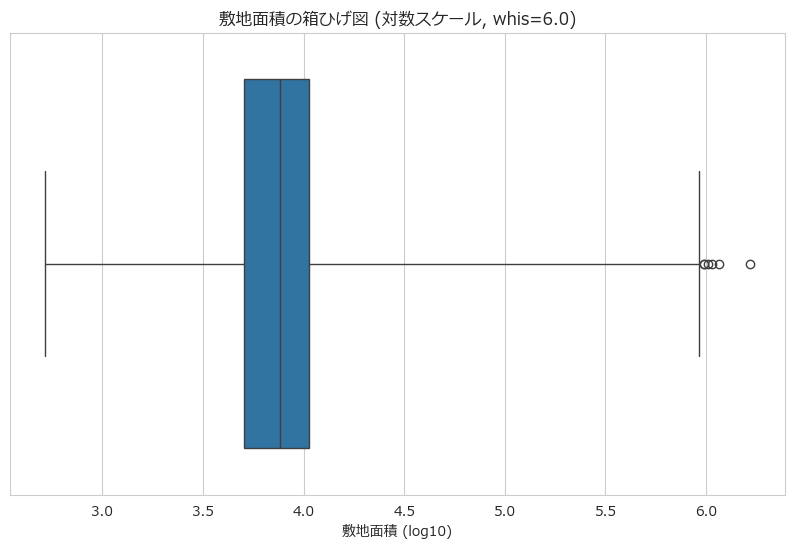

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 日本語フォントの設定
plt.rcParams['font.family'] = 'meiryo'

# カスタムwhisの設定
custom_whis = 6.0  # 例として2.0に設定

# 敷地面積の対数変換
log_sqft_lot = np.log10(data['sqft_lot'])

# 箱ひげ図の作成（カスタムwhisを使用）
plt.figure(figsize=(10, 6))
sns.boxplot(x=log_sqft_lot, whis=custom_whis)
plt.title(f"敷地面積の箱ひげ図 (対数スケール, whis={custom_whis})")
plt.xlabel("敷地面積 (log10)")
plt.show()

箱ひげ図の上限（対数スケール）: 5.99
箱ひげ図の上限（元のスケール）: 971,739.09 平方フィート
敷地面積の上限: 971,739.09 平方フィート
除外前のデータ件数: 21607
除外後のデータ件数: 21601
除外したデータの件数: 6


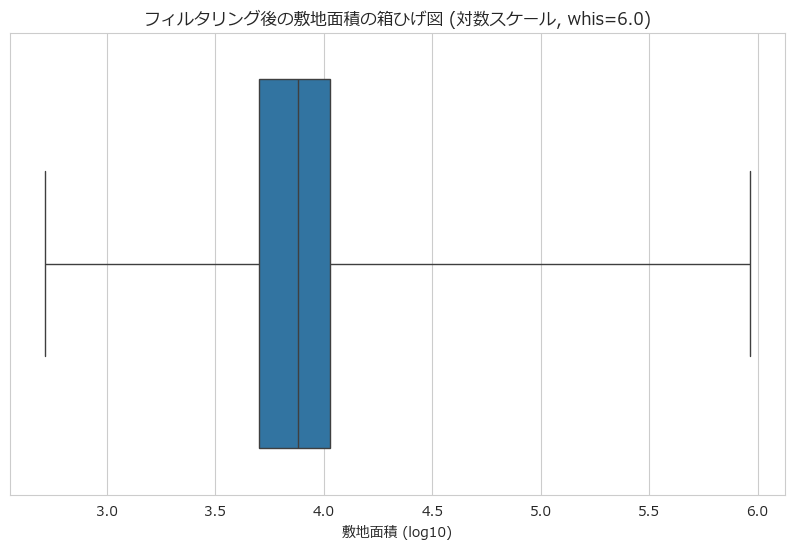

In [9]:
# 箱ひげ図の統計量を計算
Q1 = log_sqft_lot.quantile(0.25)
Q3 = log_sqft_lot.quantile(0.75)
IQR = Q3 - Q1
upper_whisker = Q3 + custom_whis * IQR
lower_whisker = Q1 - custom_whis * IQR

# 元のスケールに戻すために対数を逆変換
upper_whisker_original = 10 ** upper_whisker
lower_whisker_original = 10 ** lower_whisker

print(f"箱ひげ図の上限（対数スケール）: {upper_whisker:.2f}")
print(f"箱ひげ図の上限（元のスケール）: {upper_whisker_original:,.2f} 平方フィート")

# 敷地面積の上限を設定
upper_limit_sqft_lot = upper_whisker_original

# 敷地面積の上限を用いてデータをフィルタリング
initial_count = data.shape[0]
data_filtered = data[data['sqft_lot'] <= upper_limit_sqft_lot]
filtered_count = data_filtered.shape[0]
removed_count = initial_count - filtered_count

print(f"敷地面積の上限: {upper_limit_sqft_lot:,.2f} 平方フィート")
print(f"除外前のデータ件数: {initial_count}")
print(f"除外後のデータ件数: {filtered_count}")
print(f"除外したデータの件数: {removed_count}")

# フィルタリング後の箱ひげ図を再プロット（確認用）
log_sqft_lot_filtered = np.log10(data_filtered['sqft_lot'])

plt.figure(figsize=(10, 6))
sns.boxplot(x=log_sqft_lot_filtered, whis=custom_whis)
plt.title(f"フィルタリング後の敷地面積の箱ひげ図 (対数スケール, whis={custom_whis})")
plt.xlabel("敷地面積 (log10)")
plt.show()

2. 建築年 (yr_built) の異常値の検出と処理
問題点:

最小値が 1,900 年となっており、非常に古い物件が含まれています。これらの物件は市場特性が異なる可能性があります。
対応策:

建築年の範囲を現実的な範囲に設定し、それを超えるデータを除外します。
例えば、建築年を 1800年 から 2024年 の間に制限します。

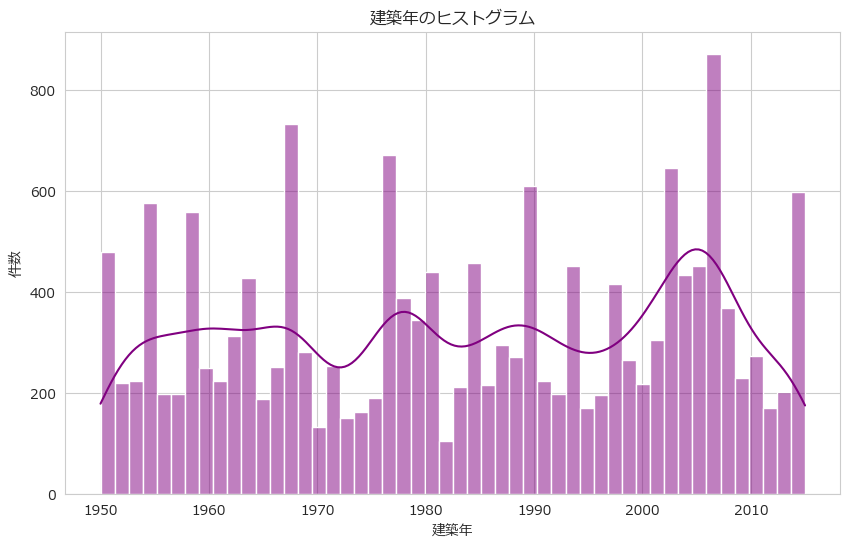

建築年の異常値除外前のデータ件数: 16674
建築年の異常値除外後のデータ件数: 16674
除外した建築年の異常値の件数: 0


In [12]:
# 建築年の分布を確認
plt.figure(figsize=(10, 6))
sns.histplot(data['yr_built'], bins=50, kde=True, color='purple')
plt.title("建築年のヒストグラム")
plt.xlabel("建築年")
plt.ylabel("件数")
plt.show()

# 建築年の範囲を設定
lower_bound_yr_built = 1950
upper_bound_yr_built = 2024
initial_count = data.shape[0]
data = data[(data['yr_built'] >= lower_bound_yr_built) & (data['yr_built'] <= upper_bound_yr_built)]
filtered_count = data.shape[0]
removed_count = initial_count - filtered_count

print(f"建築年の異常値除外前のデータ件数: {initial_count}")
print(f"建築年の異常値除外後のデータ件数: {filtered_count}")
print(f"除外した建築年の異常値の件数: {removed_count}")


3. その他の特徴量の異常値検出と処理
他にも以下のような特徴量に異常値が存在する可能性があります。

価格 (price):

非常に高額な物件（例: 最大値 7,700,000.00 USD）は市場の平均から大きく外れているため、影響を確認します。
居住スペース面積 (sqft_living):

最大値 13,540.00 平方フィートは非常に大きいため、上限を設定して除外を検討します。

In [ ]:
def remove_outliers_custom_whis(df, column, custom_whis=1.5, log_transform=False):
    """
    指定した列の異常値をカスタムwhisパラメータに基づいて除外する関数。
    
    Parameters:
    - df: pandas DataFrame
    - column: str, 処理対象の列名
    - custom_whis: float, IQRに乗じる係数（デフォルトは1.5）
    - log_transform: bool, 対数変換を行うかどうか（デフォルトはFalse）
    
    Returns:
    - フィルタリング後のDataFrame
    """
    if log_transform:
        # 対数変換
        data = np.log10(df[column])
        xlabel = f"{column} (log10)"
    else:
        data = df[column]
        xlabel = column
    
    # 箱ひげ図の作成
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data, whis=custom_whis)
    plt.title(f"{column} の箱ひげ図 (whis={custom_whis})")
    plt.xlabel(xlabel)
    plt.show()
    
    # 四分位数とIQRの計算
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    upper_whisker = Q3 + custom_whis * IQR
    lower_whisker = Q1 - custom_whis * IQR
    
    if log_transform:
        # 元のスケールに戻す
        upper_limit = 10 ** upper_whisker
        lower_limit = 10 ** lower_whisker
    else:
        upper_limit = upper_whisker
        lower_limit = lower_whisker
    
    print(f"--- {column} の異常値除外 ---")
    print(f"箱ひげ図の上限（{'対数スケール' if log_transform else '元のスケール'}）: {upper_whisker:.2f}")
    if log_transform:
        print(f"箱ひげ図の上限（元のスケール）: {upper_limit:,.2f} 平方フィート")
    print(f"{column} の上限: {upper_limit:,.2f}")
    
    # データのフィルタリング
    initial_count = df.shape[0]
    df_filtered = df[df[column] <= upper_limit]
    filtered_count = df_filtered.shape[0]
    removed_count = initial_count - filtered_count
    
    print(f"除外前のデータ件数: {initial_count}")
    print(f"除外後のデータ件数: {filtered_count}")
    print(f"除外したデータの件数: {removed_count}\n")
    
    # フィルタリング後の箱ひげ図（確認用）
    if log_transform:
        data_filtered = np.log10(df_filtered[column])
    else:
        data_filtered = df_filtered[column]
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data_filtered, whis=custom_whis)
    plt.title(f"{column} のフィルタリング後の箱ひげ図 (whis={custom_whis})")
    plt.xlabel(xlabel)
    plt.show()
    
    return df_filtered

# 処理対象の列と設定
columns_to_filter = [
    {'column': 'price', 'custom_whis': 1.5, 'log_transform': True},
    {'column': 'sqft_living', 'custom_whis': 1.5, 'log_transform': True},
    # 必要に応じて他の列を追加
]

# データフィルタリングの適用
for col in columns_to_filter:
    data = remove_outliers_custom_whis(
        df=data,
        column=col['column'],
        custom_whis=col['custom_whis'],
        log_transform=col['log_transform']
    )

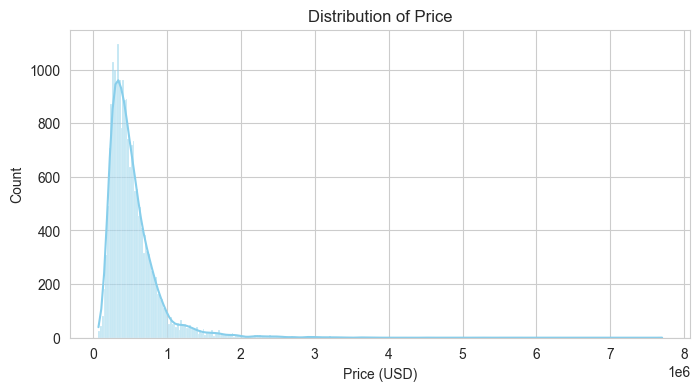

In [9]:
plt.figure(figsize=(8,4))
sns.histplot(data['price'], kde=True, color='skyblue')
plt.title("Distribution of Price")
plt.xlabel("Price (USD)")
plt.ylabel("Count")
plt.show()


価格は右裾が重い分布であり、後述するモデリング時にはlog変換を行う。

### 6.2 特徴量間の相関関係

`days_since_2014_01_01`、`renovated_flag`、`years_since_renovation` を含めて相関行列を再確認し、モデル用特徴量間の関係を把握する。


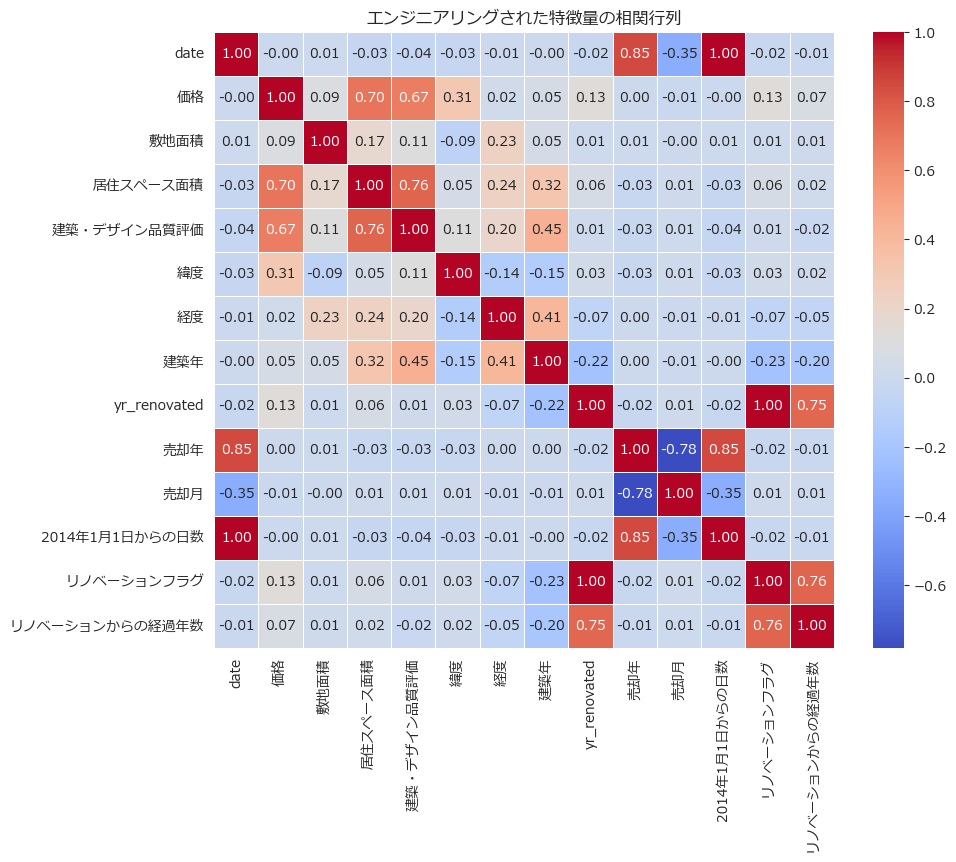

In [14]:
# カラム名を日本語に変更
japanese_columns = {
    'price': '価格',
    'sqft_lot': '敷地面積',
    'sqft_living': '居住スペース面積',
    'grade': '建築・デザイン品質評価',
    'lat': '緯度',
    'long': '経度',
    'yr_built': '建築年',
    'year_sold': '売却年',
    'month_sold': '売却月',
    'days_since_2014_01_01': '2014年1月1日からの日数',
    'renovated_flag': 'リノベーションフラグ',
    'years_since_renovation': 'リノベーションからの経過年数'
}

# 相関行列の計算
corr = data.corr()

# 相関行列のカラム名とインデックスを日本語に変更
corr_japanese = corr.rename(columns=japanese_columns, index=japanese_columns)

plt.figure(figsize=(10,8))
sns.heatmap(corr_japanese, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("エンジニアリングされた特徴量の相関行列")
plt.show()


`sqft_living`、`grade` が `price` と強い相関を示す。  
`renovated_flag` や `years_since_renovation` は `price` との相関は弱めだが、リノベ済物件は価格アップに寄与している可能性があるため、非線形モデルでの有用性に期待。

### 6.3 リノベーション関連の可視化

リノベーション有無による価格差を簡易に確認する。


findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.


findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Fon

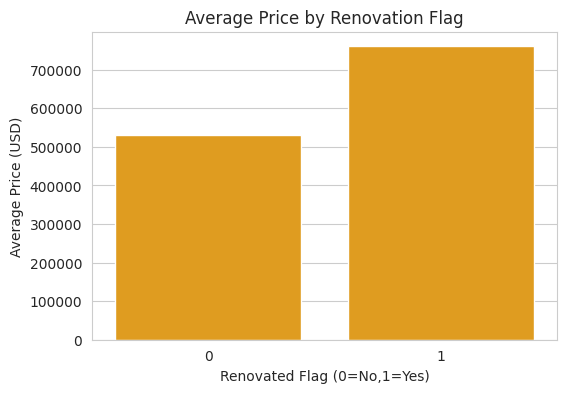

In [8]:
renovation_price = data.groupby('renovated_flag')['price'].mean().reset_index()
plt.figure(figsize=(6,4))
sns.barplot(x='renovated_flag', y='price', data=renovation_price, color='orange')
plt.title("Average Price by Renovation Flag")
plt.xlabel("Renovated Flag (0=No,1=Yes)")
plt.ylabel("Average Price (USD)")
plt.show()


リノベ済物件の平均価格が未リノベ物件より高い傾向があるため、`renovated_flag` は一定の情報を提供すると考えられる。

## 7. モデル構築

本分析ではXGBoostを用いる。

### 7.1 学習・テスト分割とターゲット変換


In [9]:
X = data[[
    'sqft_lot','sqft_living','grade','lat','long','yr_built',
    'year_sold','month_sold','days_since_2014_01_01',
    'renovated_flag','years_since_renovation'
]]
y = np.log1p(data['price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 7.2 モデル学習 (XGBoost)


In [10]:
import xgboost as xgb

xg_model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')
xg_model.fit(X_train, y_train)

y_pred = xg_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"XGBoost RMSE: {rmse:,.2f}")
print(f"XGBoost MAE : {mae:,.2f}")


XGBoost RMSE: 0.18
XGBoost MAE : 0.13


### 7.3 ハイパーパラメータチューニング


In [11]:
param_grid = {'n_estimators': [100, 200], 'max_depth': [3,5,7]}
xg_cv = GridSearchCV(
    xgb.XGBRegressor(random_state=42, objective='reg:squarederror'),
    param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1
)
xg_cv.fit(X_train, y_train)

print("Best Parameters:", xg_cv.best_params_)
best_xg = xg_cv.best_estimator_
y_pred_best = best_xg.predict(X_test)

rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
mae_best = mean_absolute_error(y_test, y_pred_best)

print(f"Tuned XGBoost RMSE: {rmse_best:,.2f}")
print(f"Tuned XGBoost MAE : {mae_best:,.2f}")


Best Parameters: {'max_depth': 5, 'n_estimators': 100}
Tuned XGBoost RMSE: 0.18
Tuned XGBoost MAE : 0.13


8.1 実測値 vs 予測値 (Log Scale)

findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Fon

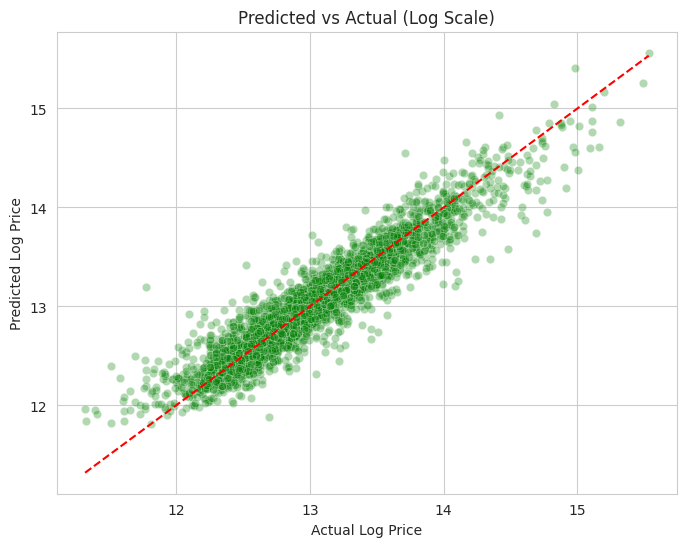

In [12]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=y_test, 
    y=y_pred_best, 
    alpha=0.3, 
    color='green'
)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Predicted vs Actual (Log Scale)")
plt.xlabel("Actual Log Price")
plt.ylabel("Predicted Log Price")
plt.show()
